# Evolver Loop 3 Analysis

## Objective
Analyze the current lattice initialization strategy and the evaluator's feedback regarding the "Square Peg in Round Hole" problem.

## Current Status
- Best CV: 77.66
- Target: ~69
- Gap: ~8.6 points
- Current Lattice Density: 0.8728
- Current Crop Shape: Circular (sorted by $x^2 + y^2$)

## Evaluator's Hypothesis
The evaluator suggests that sorting by Chebyshev distance (L-infinity norm) will create a square crop, which better fits the square bounding box target.
Theoretical improvement:
- Circular crop waste: ~21.5%
- Square crop waste: ~0% (ideal)

## Analysis Plan
1. Visualize the current circular crop vs proposed square crop for N=200.
2. Calculate the theoretical bounding box size for both.
3. Verify the density calculation.


Unit Cell Area: 0.5628
Tree Area: 0.2456
Density: 0.8728
N=200
Circular Crop Score: 0.3461
Square Crop Score:   0.2823
Improvement: 0.0637


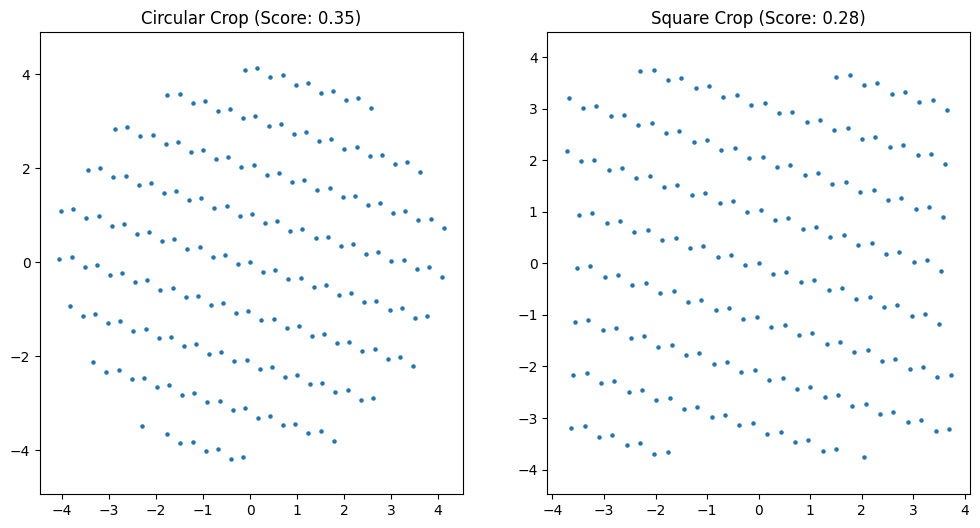

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely import affinity

# Tree definition
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]
TREE_COORDS = list(zip(TX, TY))
TREE_POLY = Polygon(TREE_COORDS)
TREE_AREA = TREE_POLY.area

# Optimized parameters from Experiment 2
v1 = np.array([0.53770751, -0.16283756])
v2 = np.array([-0.49997463, 1.1981019])
offset = np.array([0.3152888, 0.83522419])

# Unit cell area
unit_cell_area = abs(np.cross(v1, v2))
density = (2 * TREE_AREA) / unit_cell_area
print(f"Unit Cell Area: {unit_cell_area:.4f}")
print(f"Tree Area: {TREE_AREA:.4f}")
print(f"Density: {density:.4f}")

def generate_candidates(N):
    candidates = []
    K = int(np.ceil(np.sqrt(N))) + 5
    for i in range(-K, K+1):
        for j in range(-K, K+1):
            # Up tree
            pos_up = i * v1 + j * v2
            candidates.append({'x': pos_up[0], 'y': pos_up[1], 'deg': 0})
            # Down tree
            pos_down = offset + i * v1 + j * v2
            candidates.append({'x': pos_down[0], 'y': pos_down[1], 'deg': 180})
    return candidates

def get_bbox(selected):
    min_x = min(p['x'] for p in selected)
    max_x = max(p['x'] for p in selected)
    min_y = min(p['y'] for p in selected)
    max_y = max(p['y'] for p in selected)
    return max(max_x - min_x, max_y - min_y)

N = 200
candidates = generate_candidates(N)

# Circular Crop
candidates_circ = sorted(candidates, key=lambda p: p['x']**2 + p['y']**2)[:N]
bbox_circ = get_bbox(candidates_circ)
score_circ = (bbox_circ**2) / N

# Square Crop (Chebyshev)
# Note: Chebyshev distance is max(|x|, |y|).
# However, the lattice is rotated. We want a square aligned with the axes.
# So sorting by max(|x|, |y|) is correct for axis-aligned square.
candidates_sq = sorted(candidates, key=lambda p: max(abs(p['x']), abs(p['y'])))[:N]
bbox_sq = get_bbox(candidates_sq)
score_sq = (bbox_sq**2) / N

print(f"N={N}")
print(f"Circular Crop Score: {score_circ:.4f}")
print(f"Square Crop Score:   {score_sq:.4f}")
print(f"Improvement: {score_circ - score_sq:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter([p['x'] for p in candidates_circ], [p['y'] for p in candidates_circ], s=5)
plt.title(f"Circular Crop (Score: {score_circ:.2f})")
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter([p['x'] for p in candidates_sq], [p['y'] for p in candidates_sq], s=5)
plt.title(f"Square Crop (Score: {score_sq:.2f})")
plt.axis('equal')
plt.show()
